# Analysis of specific experiments
- tracked via Weights & Biases
- tracked via Optuna

In [ ]:
import wandb
import matplotlib.pyplot as plt
import pandas as pd
from scipy.ndimage import gaussian_filter1d
from matplotlib import rcParams

import optuna
from matplotlib.ticker import FuncFormatter
import optuna.visualization.matplotlib as ovm

rcParams['font.family'] = 'Times New Roman'

### WandB Experiment Evaluation

#### Define WandB Parameters

In [ ]:
wandb_entity = "ml-data-challenge-24"
wandb_project = "ml-data-challenge-24"

wandb_run_ids_ablation_study = [
    "l20vspfr", 
    "kxf6mtmn",
    "x6uuplgi",
    "6j5igeet",
    "58glcu8l",
    "51ibroqo"
]

wandb_run_ids_model_comparisons = [
    "ez0sw27z", # removed matches
    "n9hbb16f", # roberta (pre-comp)
    "xgncrt65", # bert (pre-comp)
    "xifr0tov", # bert (fine-tuned)
    "39f501y7", # longformer (fine-tuned)
]


wandb_run_ids = wandb_run_ids_model_comparisons

#### Get data from WandB

In [ ]:
all_runs = []
api = wandb.Api()

for run_id in wandb_run_ids:
    print(f"Fetching data for run ID: {run_id}")
    try:
        run = api.run(f"{wandb_entity}/{wandb_project}/{run_id}")
        
        history = run.history(pandas=True)
        
        if "eval/accuracy" not in history.columns or "train/epoch" not in history.columns:
            print(f"Run {run_id} does not contain 'eval/accuracy' or '_epoch'. Skipping.")
            continue

        eval_accuracy = history["eval/accuracy"]
        epoch = history["train/epoch"]  
        
        df = pd.DataFrame({
            "epoch": epoch,
            "eval_accuracy": eval_accuracy,
            "run_id": run_id,
            "run_name": run.name
        })
        all_runs.append(df)
    except Exception as e:
        print(f"Error fetching data for run ID {run_id}: {e}")

if all_runs:
    results_df = pd.concat(all_runs, ignore_index=True)
    print("Data successfully aggregated.")
else:
    print("No valid data was found for the specified runs.")
    results_df = pd.DataFrame()

results_df = results_df[results_df["eval_accuracy"].notnull()]
results_df = results_df[results_df["epoch"] <= 30]

accuracy_stats = results_df.groupby("run_id")["eval_accuracy"].agg(["mean", "max"]).reset_index()
accuracy_stats.rename(columns={"mean": "avg_accuracy", "max": "max_accuracy"}, inplace=True)

accuracy_stats["avg_accuracy"] = accuracy_stats["avg_accuracy"].round(2)
accuracy_stats["max_accuracy"] = accuracy_stats["max_accuracy"].round(2)

results_df = results_df.merge(accuracy_stats, on="run_id")

results_df

Fetching data for run ID: ez0sw27z
Fetching data for run ID: n9hbb16f
Fetching data for run ID: xgncrt65
Fetching data for run ID: xifr0tov
Fetching data for run ID: 39f501y7
Data successfully aggregated.


,epoch,eval_accuracy,run_id,run_name,avg_accuracy,max_accuracy
0,1.000000,0.676471,ez0sw27z,vinai/bertweet-base-attention-FROZEN-filtered,0.67,0.74
1,2.000000,0.617647,ez0sw27z,vinai/bertweet-base-attention-FROZEN-filtered,0.67,0.74
2,3.000000,0.529412,ez0sw27z,vinai/bertweet-base-attention-FROZEN-filtered,0.67,0.74
3,4.000000,0.617647,ez0sw27z,vinai/bertweet-base-attention-FROZEN-filtered,0.67,0.74
4,5.000000,0.705882,ez0sw27z,vinai/bertweet-base-attention-FROZEN-filtered,0.67,0.74
...,...,...,...,...,...,...
108,3.991684,0.761682,39f501y7,allenai/longformer-base-4096-agg-lr-1e-05-epoc...,0.71,0.78
109,4.989605,0.780374,39f501y7,allenai/longformer-base-4096-agg-lr-1e-05-epoc...,0.71,0.78
110,5.987526,0.775701,39f501y7,allenai/longformer-base-4096-agg-lr-1e-05-epoc...,0.71,0.78
111,6.985447,0.738318,39f501y7,allenai/longformer-base-4096-agg-lr-1e-05-epoc...,0.71,0.78


### Plot data for Ablation Study

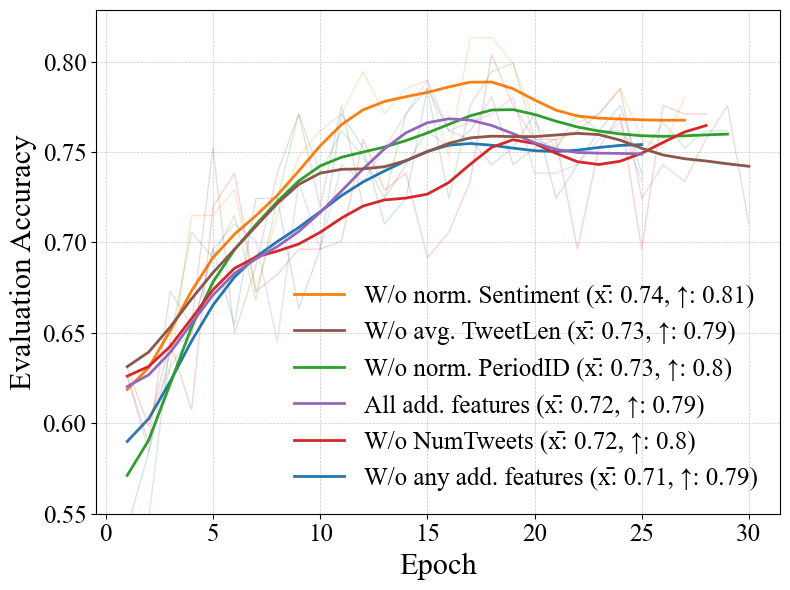

In [ ]:

base_custom_legend_labels = {
    "l20vspfr": "All add. features",
    "kxf6mtmn": "W/o NumTweets",
    "x6uuplgi": "W/o avg. TweetLen",
    "6j5igeet": "W/o norm. PeriodID",
    "58glcu8l": "W/o norm. Sentiment",
    "51ibroqo": "W/o any add. features"
}

custom_legend_labels = {
    run_id: f"{label} (x̄: {accuracy_stats.loc[accuracy_stats['run_id'] == run_id, 'avg_accuracy'].values[0]}, ↑: {accuracy_stats.loc[accuracy_stats['run_id'] == run_id, 'max_accuracy'].values[0]})"
    for run_id, label in base_custom_legend_labels.items()
}

sorted_legend_labels = sorted(
    custom_legend_labels.items(),
    key=lambda item: accuracy_stats.loc[accuracy_stats["run_id"] == item[0], "avg_accuracy"].values[0],
    reverse=True 
)

if not results_df.empty:
    plt.figure(figsize=(8, 6)) 

    colors = plt.cm.tab10.colors 

    line_handles = {}

    for idx, (run_id, group) in enumerate(results_df.groupby("run_id")):

        smoothed_accuracy = gaussian_filter1d(group["eval_accuracy"], sigma=2) 

        legend_label = custom_legend_labels.get(run_id, f"Run {run_id} (x̄: {group['avg_accuracy'].iloc[0]:.2f}, ↑: {group['max_accuracy'].iloc[0]:.2f})")

        plt.plot(
            group["epoch"], 
            group["eval_accuracy"], 
            color=colors[idx % len(colors)], 
            alpha=0.2,
            linewidth=1 
        )

        line, = plt.plot(
            group["epoch"], 
            smoothed_accuracy, 
            label=legend_label,
            color=colors[idx % len(colors)],
            markersize=7, 
            linewidth=2 
        )
        line_handles[run_id] = line

    plt.xlabel("Epoch", fontsize=22, family="Times New Roman")
    plt.ylabel("Evaluation Accuracy", fontsize=22, family="Times New Roman")
    plt.xticks(fontsize=18, family="Times New Roman")
    plt.yticks(fontsize=18, family="Times New Roman")
    plt.grid(visible=True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

    plt.ylim(0.55, None)

    plt.legend(
        handles=[line_handles[run_id] for run_id, _ in sorted_legend_labels],
        labels=[label for _, label in sorted_legend_labels],
        fontsize=18,
        frameon=False,
        ncol=1,
        columnspacing=0.5,
    )

    plt.tight_layout()

    plt.savefig("ablation_study.pdf", dpi=300, bbox_inches="tight")
    plt.show()

### Plot data for different model comparisons

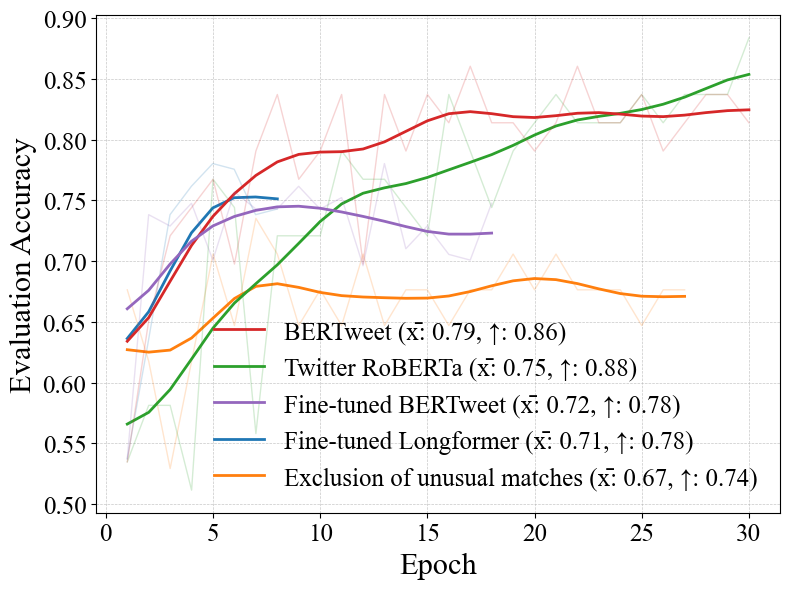

In [ ]:
base_custom_legend_labels = {
    "ez0sw27z": "Exclusion of unusual matches",
    "n9hbb16f": "Twitter RoBERTa",
    "xgncrt65": "BERTweet",
    "xifr0tov": "Fine-tuned BERTweet",
    "39f501y7": "Fine-tuned Longformer",
}

custom_legend_labels = {
    run_id: f"{label} (x̄: {accuracy_stats.loc[accuracy_stats['run_id'] == run_id, 'avg_accuracy'].values[0]}, ↑: {accuracy_stats.loc[accuracy_stats['run_id'] == run_id, 'max_accuracy'].values[0]})"
    for run_id, label in base_custom_legend_labels.items()
}

sorted_legend_labels = sorted(
    custom_legend_labels.items(),
    key=lambda item: accuracy_stats.loc[accuracy_stats["run_id"] == item[0], "avg_accuracy"].values[0],
    reverse=True 
)


if not results_df.empty:
    plt.figure(figsize=(8, 6)) 

    colors = plt.cm.tab10.colors 
    line_handles = {}
    for idx, (run_id, group) in enumerate(results_df.groupby("run_id")):

        smoothed_accuracy = gaussian_filter1d(group["eval_accuracy"], sigma=2)
        legend_label = custom_legend_labels.get(run_id, f"Run {run_id} (x̄: {group['avg_accuracy'].iloc[0]:.2f}, ↑: {group['max_accuracy'].iloc[0]:.2f})")

        plt.plot(
            group["epoch"], 
            group["eval_accuracy"], 
            color=colors[idx % len(colors)], 
            alpha=0.2,
            linewidth=1
        )
        
        line, = plt.plot(
            group["epoch"], 
            smoothed_accuracy, 
            label=legend_label,
            color=colors[idx % len(colors)], 
            markersize=7,
            linewidth=2 
        )
        line_handles[run_id] = line

    plt.xlabel("Epoch", fontsize=22, family="Times New Roman")
    plt.ylabel("Evaluation Accuracy", fontsize=22, family="Times New Roman")
    plt.xticks(fontsize=18, family="Times New Roman")
    plt.yticks(fontsize=18, family="Times New Roman")
    plt.grid(visible=True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

    plt.legend(
        handles=[line_handles[run_id] for run_id, _ in sorted_legend_labels],
        labels=[label for _, label in sorted_legend_labels],
        fontsize=18,
        frameon=False,
        ncol=1, 
        columnspacing=0.5,
    )

    plt.tight_layout()

    plt.savefig("model_comparison.pdf", dpi=300, bbox_inches="tight")
    plt.show()

### Optuna Evaluation

In [ ]:
study_name = "EnhancedPeriodClassifier_HPO"
db_path = '/Data/tlh45/hpo_study_new.db'
storage_url = f"sqlite:///{db_path}"
study = optuna.load_study(study_name=study_name, storage=storage_url)

df = study.trials_dataframe(attrs=("number", "value", "params", "state", "datetime_start", "datetime_complete"))

df_limited = df.head(30)

print(f"Succesfully loaded {len(df_limited)} trials (limited to 30).")
print("Trials DataFrame:")
df_limited.head()

Succesfully loaded 30 trials (limited to 30).
Trials DataFrame:


,number,value,params_dropout_prob,params_fc1_dim,params_learning_rate,params_num_heads,params_weight_decay,state,datetime_start,datetime_complete
0,0,0.771028,0.480286,1024,0.000056,4,0.000004,COMPLETE,2024-12-08 14:38:48.575693,2024-12-08 15:37:28.642855
1,1,0.742991,0.487964,1024,0.000011,4,0.000005,COMPLETE,2024-12-08 15:37:28.668776,2024-12-08 16:32:27.562986
2,2,0.771028,0.155798,2048,0.000167,12,0.001383,COMPLETE,2024-12-08 16:32:27.588093,2024-12-08 17:10:50.068161
3,3,0.747664,0.168210,2048,0.000164,12,0.001712,COMPLETE,2024-12-08 17:10:50.093099,2024-12-08 18:19:08.816417
4,4,0.733645,0.298071,2048,0.000018,8,0.000447,COMPLETE,2024-12-08 18:19:08.842169,2024-12-08 19:12:22.559932


#### Summary


Best Trial:
  Trial Number: 21
  Value: 0.8037383177570093
  Parameters:
    learning_rate: 0.0002075340613826246
    dropout_prob: 0.10055127505899107
    num_heads: 12
    weight_decay: 0.0023022303078378396
    fc1_dim: 2048


/tmp/ipykernel_2332512/3267596799.py:11: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


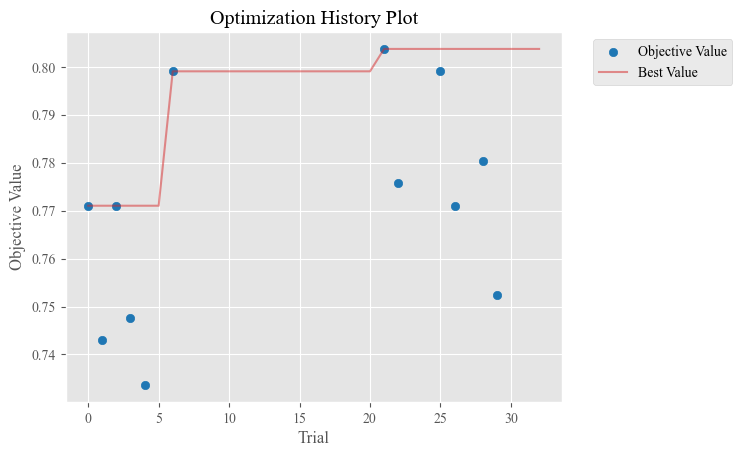

/tmp/ipykernel_2332512/3267596799.py:15: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


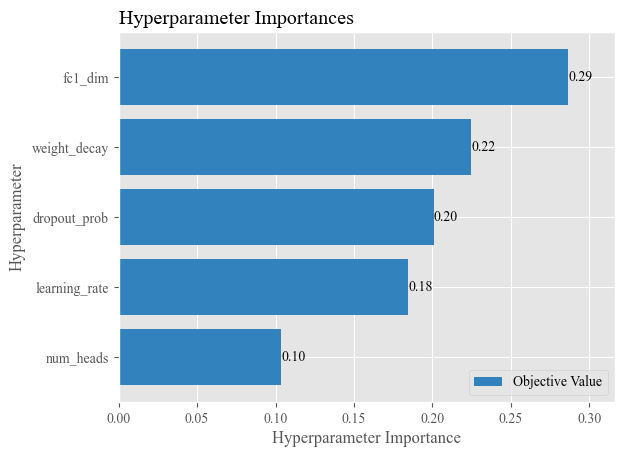

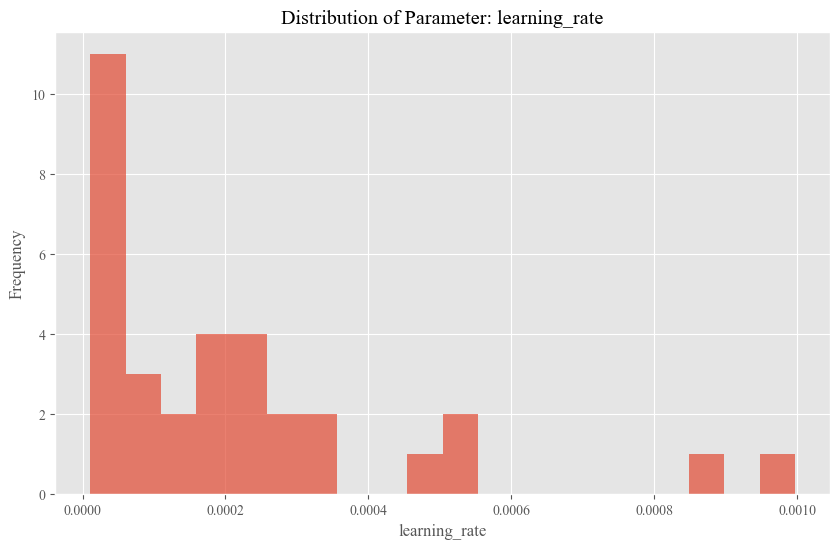

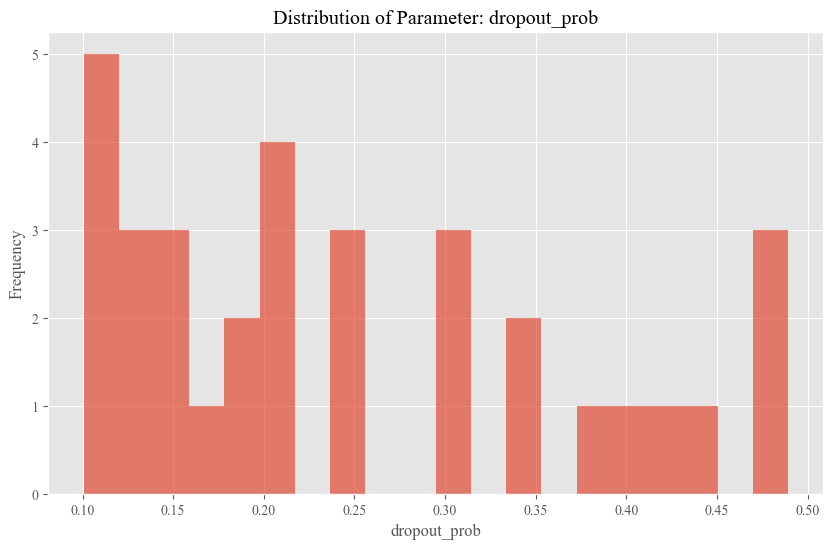

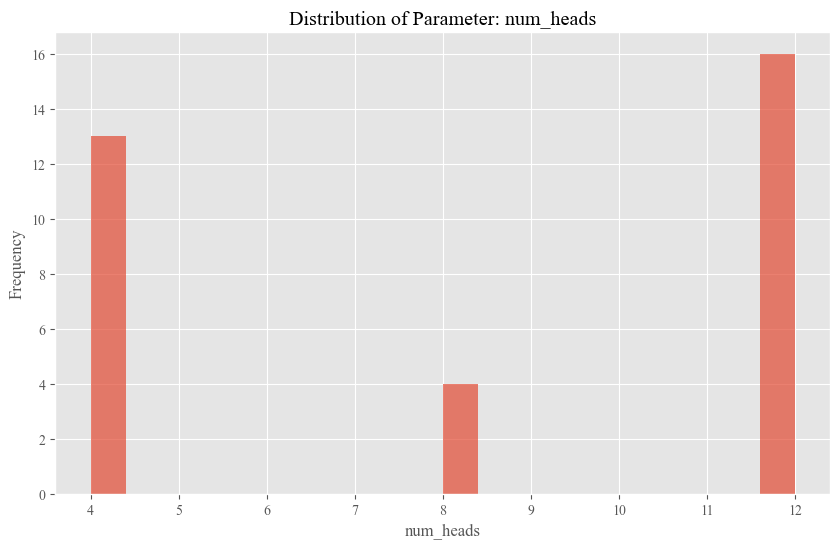

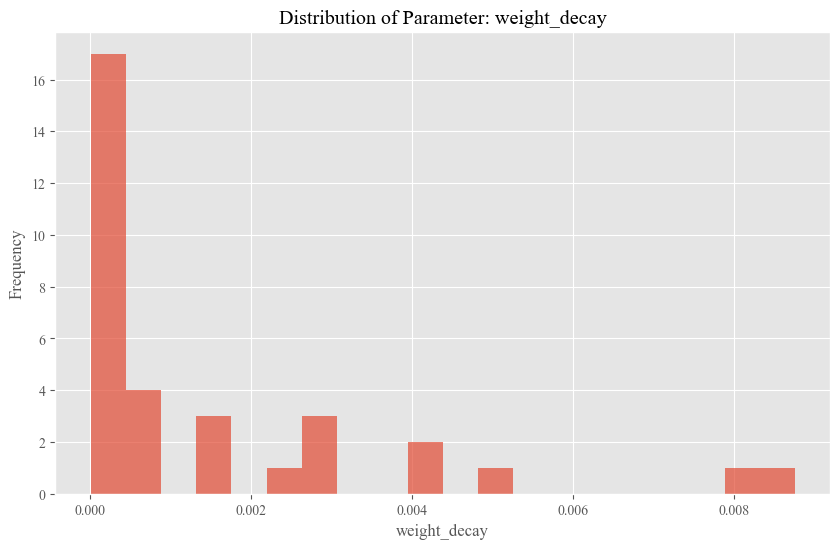

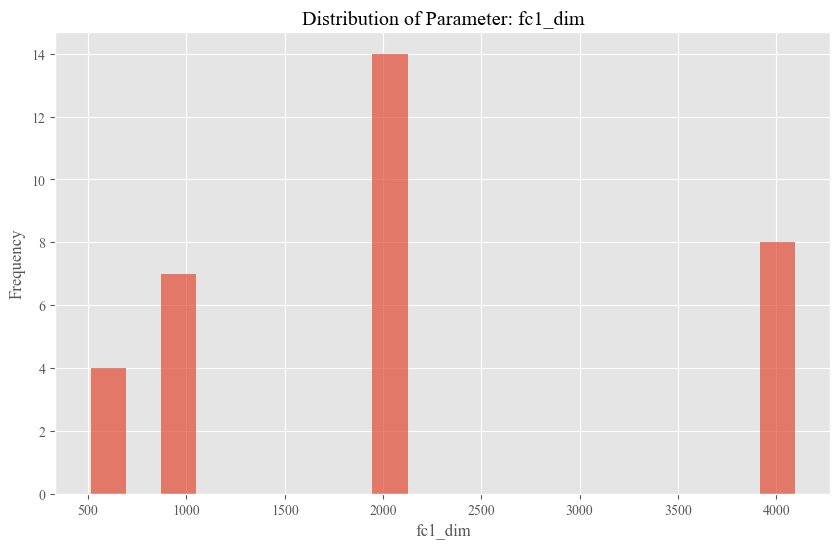

In [ ]:
best_trial = study.best_trial
print("\nBest Trial:")
print(f"  Trial Number: {best_trial.number}")
print(f"  Value: {best_trial.value}")
print("  Parameters:")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

optuna.visualization.matplotlib.plot_optimization_history(study)
plt.show()

optuna.visualization.matplotlib.plot_param_importances(study)
plt.show()

for param in best_trial.params.keys():
    plt.figure(figsize=(10, 6))
    plt.hist(df[f'params_{param}'].dropna().astype(float), bins=20, alpha=0.7)
    plt.title(f"Distribution of Parameter: {param}")
    plt.xlabel(param)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

#### Plot of optimization history

[I 2024-12-09 12:51:31,479] A new study created in memory with name: no-name-a7e5bef4-766b-448e-98f4-e4b17923cd79


/tmp/ipykernel_2332512/3969740283.py:11: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(limited_study)


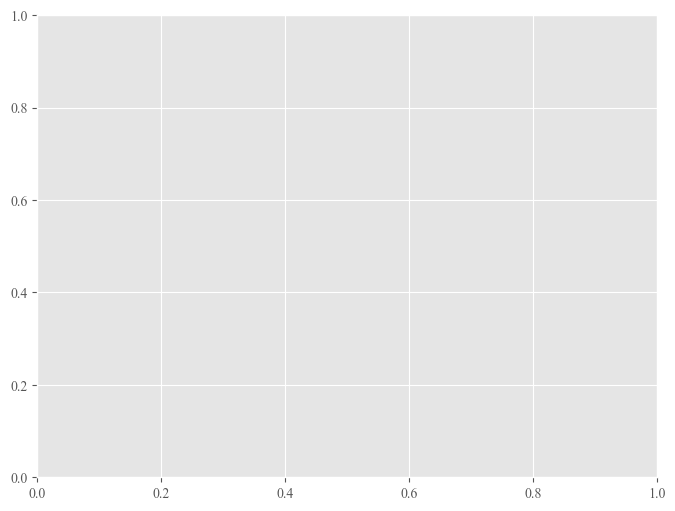

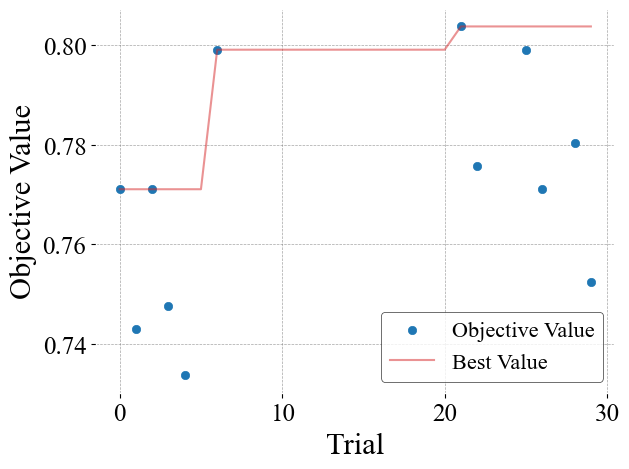

In [ ]:
limited_trials = study.trials[:30]

limited_study = optuna.create_study(direction=study.direction)
for trial in limited_trials:
    limited_study.add_trial(trial)
fig, ax = plt.subplots(figsize=(8, 6)) 
optuna.visualization.matplotlib.plot_optimization_history(limited_study)

ax = plt.gca()

ax.set_title('')
ax.set_xlabel("Trial", fontsize=22, color="black", family="Times New Roman")
ax.set_ylabel("Objective Value", fontsize=22, color="black", family="Times New Roman")
ax.tick_params(axis="x", labelsize=18, colors="black")
ax.tick_params(axis="y", labelsize=18, colors="black")

ax.set_facecolor("white")
ax.grid(axis="both", linestyle="--", linewidth=0.5, alpha=0.7, color="gray")

ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.0f}"))
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y:.2f}"))

legend = ax.legend(
    loc='lower right',  
    fontsize=16, 
    frameon=True  
)
legend.get_frame().set_facecolor('white')
legend.get_frame().set_edgecolor('black') 

plt.tight_layout()

plt.savefig("optimization_history_limited.pdf", dpi=300, bbox_inches="tight")
plt.show()

#### Plot importance of hyperparameters

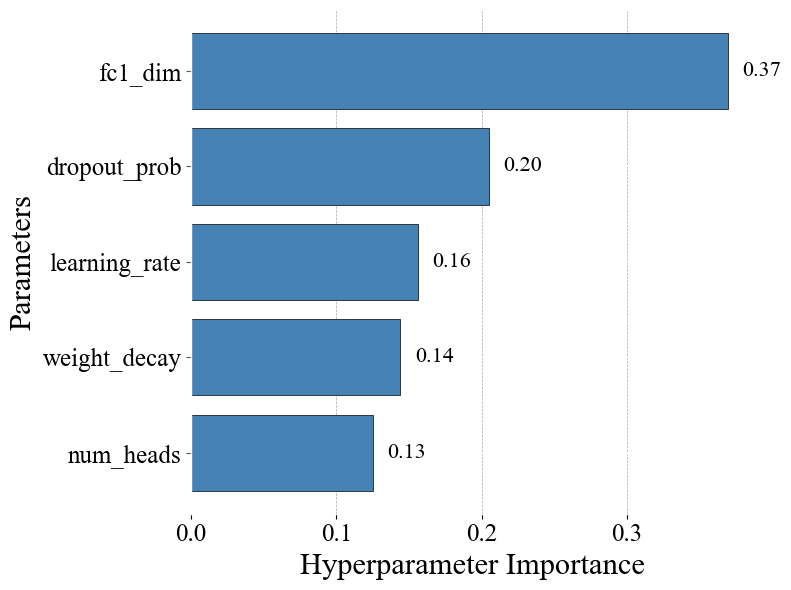

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

importance = optuna.importance.get_param_importances(study)

importance_df = pd.DataFrame(list(importance.items()), columns=["Parameter", "Importance"])

importance_df = importance_df.sort_values(by="Importance", ascending=True)

bars = ax.barh(
    importance_df["Parameter"], 
    importance_df["Importance"], 
    color="steelblue",
    edgecolor="black" 
)
ax.set_facecolor("white")

ax.set_xlabel("Hyperparameter Importance", fontsize=22, color="black", family="Times New Roman")
ax.set_ylabel("Parameters", fontsize=22, color="black", family="Times New Roman")
ax.set_yticks(range(len(importance_df["Parameter"])))
ax.set_yticklabels(importance_df["Parameter"], fontsize=18, color="black", family="Times New Roman")
ax.tick_params(axis="x", labelsize=18, colors="black")

ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.1f}"))

ax.grid(axis="x", linestyle="--", linewidth=0.5, alpha=0.7, color="gray")

for bar in bars:
    ax.text(
        bar.get_width() + 0.01,
        bar.get_y() + bar.get_height() / 2,
        f"{bar.get_width():.2f}",
        va="center", 
        fontsize=16, 
        color="black",
        family="Times New Roman"
    )
plt.tight_layout()
plt.savefig("hp_importance.pdf", dpi=300, bbox_inches="tight")
plt.show()

#### Get Details in table for report

In [ ]:
latex_df = df_limited.rename(columns={
    "number": "Trial",
    "value": "Accuracy",
    "state": "State",
    "datetime_start": "Start Time",
    "datetime_complete": "End Time"
})

params_columns = [col for col in latex_df.columns if col.startswith("params_")]
latex_df = latex_df[["Trial", "Accuracy"] + params_columns]

latex_df = latex_df.rename(columns={
    "params_dropout_prob": "Dropout",
    "params_learning_rate": "Learning Rate",
    "params_weight_decay": "Weight Decay",
    "params_fc1_dim": "FC1 Dim",
    "params_num_heads": "Num Heads",
})

columns_to_round = {
    "Accuracy": 3,
    "Dropout": 2,
    "Learning Rate": 1,
    "Weight Decay": 1
}

for col, precision in columns_to_round.items():
    if col in latex_df.columns:
        if "Learning Rate" in col or "Weight Decay" in col:
            latex_df[col] = latex_df[col].apply(lambda x: f"{x:.1e}".rstrip("0").rstrip("e-").replace("e-0", "e-") if not pd.isna(x) else x)
        else:
            latex_df[col] = latex_df[col].apply(lambda x: f"{x:.{precision}f}".rstrip("0").rstrip(".") if not pd.isna(x) else x)

latex_df["Accuracy"] = pd.to_numeric(latex_df["Accuracy"], errors="coerce")
max_acc_index = latex_df["Accuracy"].idxmax()

latex_rows = []
for idx, row in latex_df.iterrows():
    row_str = " & ".join(map(str, row.values))
    if idx == max_acc_index:
        latex_rows.append(f"\\rowcolor[gray]{{0.9}} {row_str} \\\\")
    else:
        latex_rows.append(f"{row_str} \\\\")

latex_code = f"""
\\begin{{table}}[ht]
\\centering
\\begin{{tabular}}{{{'c' * (len(latex_df.columns))}}}
\\toprule
{' & '.join(latex_df.columns)} \\\\
\\midrule
{''.join(latex_rows)}
\\bottomrule
\\end{{tabular}}
\\caption{{Summary of the Optuna Hyperparameter Optimization for the \\textit{{EnhancedPeriodClassifier}}.}}
\\label{{tab:optuna_summary}}
\\end{{table}}
"""

print(latex_code)


\begin{table}[ht]
\centering
\begin{tabular}{ccccccc}
\toprule
Trial & Accuracy & Dropout & FC1 Dim & Learning Rate & Num Heads & Weight Decay \\
\midrule
0 & 0.771 & 0.48 & 1024 & 5.6e-5 & 4 & 4.2e-6 \\1 & 0.743 & 0.49 & 1024 & 1.1e-5 & 4 & 5.4e-6 \\2 & 0.771 & 0.16 & 2048 & 1.7e-4 & 12 & 1.4e-3 \\3 & 0.748 & 0.17 & 2048 & 1.6e-4 & 12 & 1.7e-3 \\4 & 0.734 & 0.3 & 2048 & 1.8e-5 & 8 & 4.5e-4 \\5 & 0.589 & 0.41 & 4096 & 8.7e-4 & 4 & 4.9e-3 \\6 & 0.799 & 0.21 & 4096 & 6.0e-5 & 4 & 1.5e-4 \\7 & 0.617 & 0.18 & 512 & 3.5e-4 & 8 & 8.2e-4 \\8 & 0.654 & 0.35 & 2048 & 5.3e-4 & 4 & 2.0e-5 \\9 & 0.407 & 0.39 & 512 & 1.7e-5 & 12 & 9.4e-5 \\10 & 0.659 & 0.25 & 4096 & 5.8e-5 & 4 & 6.1e-5 \\11 & 0.584 & 0.49 & 1024 & 4.9e-5 & 4 & 1.4e-6 \\12 & 0.72 & 0.25 & 1024 & 4.9e-5 & 4 & 1.5e-5 \\13 & 0.621 & 0.24 & 4096 & 9.0e-5 & 4 & 1.1e-6 \\14 & 0.57 & 0.11 & 1024 & 3.0e-5 & 4 & 2.3e-4 \\15 & 0.612 & 0.31 & 4096 & 1.5e-4 & 8 & 2.9e-5 \\16 & 0.715 & 0.41 & 4096 & 7.5e-5 & 4 & 3.0e-6 \\17 & 0.575 & 0.45 & 102